In [0]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

import matplotlib.image  as mtimg
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import os
import zipfile
from shutil import copyfile

In [3]:
# Get the data

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2019-08-10 08:47:53--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.75.172.154, 2a02:26f0:7b:895::e59, 2a02:26f0:7b:89d::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.75.172.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  70.9MB/s    in 12s     

2019-08-10 08:48:05 (64.4 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [4]:
# Check # of images per category
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [0]:
os.mkdir('/tmp/DATA')
os.mkdir('/tmp/DATA/train')
os.mkdir('/tmp/DATA/test')
os.mkdir('/tmp/DATA/train/cats')
os.mkdir('/tmp/DATA/train/dogs')
os.mkdir('/tmp/DATA/test/cats')
os.mkdir('/tmp/DATA/test/dogs')

# os.mkdir('/tmp/DATA/__TEST')

In [6]:
os.listdir('/tmp/DATA')

['test', 'train']

In [0]:
def split_data(source, dest_train, dest_test, train_size = .9):
    
    files = []
       
    for filename in os.listdir(source):
            
        if os.path.getsize(os.path.join(source, filename)) > 0:
            files.append(filename)
        else:
            print(f'The file {filename} has zero size. Will be ignored.')
            
    train_size = int(len(files) * train_size)
            
    shuffled = np.random.choice(files, len(files), replace = False)
    
    train_set = shuffled[:train_size]
    test_set  = shuffled[train_size:]
    
    for name in train_set:
        src_path = os.path.join(source, name)
        dst_path = os.path.join(dest_train, name)
        copyfile(src_path, dst_path)
        
    for name in test_set:
        src_path = os.path.join(source, name)
        dst_path = os.path.join(dest_test, name)
        copyfile(src_path, dst_path)

In [8]:
split_data('/tmp/PetImages/Cat', '/tmp/DATA/train/cats', '/tmp/DATA/test/cats')
split_data('/tmp/PetImages/Dog', '/tmp/DATA/train/dogs', '/tmp/DATA/test/dogs')

The file 666.jpg has zero size. Will be ignored.
The file 11702.jpg has zero size. Will be ignored.


In [9]:
print(len(os.listdir('/tmp/DATA/train/cats')))
print(len(os.listdir('/tmp/DATA/train/dogs')))
print(len(os.listdir('/tmp/DATA/test/cats')))
print(len(os.listdir('/tmp/DATA/test/dogs')))

11250
11250
1250
1250


In [10]:
# Build the model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

W0810 08:49:18.852034 140064798791552 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0810 08:49:19.076399 140064798791552 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
# Define image generators
train_dir = '/tmp/DATA/train'
test_dir  = '/tmp/DATA/test'


# Train
train_datagen = ImageDataGenerator(rescale            = 1/255,
                                   rotation_range     = 45, 
                                   width_shift_range  = .2,
                                   height_shift_range = .2,
                                   shear_range        = .3,
                                   zoom_range         = .25,
                                   horizontal_flip    = True,
                                   fill_mode          = 'nearest')


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size  = 100,
                                                    class_mode  = 'binary',
                                                    target_size = (150, 150))


# Test
valid_datagen = ImageDataGenerator(rescale            = 1/255,
                                   rotation_range     = 45,
                                   width_shift_range  = .2,
                                   height_shift_range = .2,
                                   shear_range        = .3,
                                   zoom_range         = .25,
                                   horizontal_flip    = True,
                                   fill_mode          = 'nearest')

valid_generator = valid_datagen.flow_from_directory(test_dir,
                                                    batch_size  = 100,
                                                    class_mode  = 'binary',
                                                    target_size = (150, 150))


# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [15]:
history = model.fit_generator(train_generator,
                              epochs          = 15,
                              verbose         = 1,
                              validation_data = valid_generator)

Epoch 1/15
 10/225 [>.............................] - ETA: 2:21 - loss: 1.2820 - acc: 0.4970

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

 80/225 [=========>....................] - ETA: 1:42 - loss: 0.7739 - acc: 0.5326

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

110/225 [=============>................] - ETA: 1:21 - loss: 0.7482 - acc: 0.5436

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


162/225 [====================>.........] - ETA: 44s - loss: 0.7260 - acc: 0.5532

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

177/225 [======================>.......] - ETA: 33s - loss: 0.7212 - acc: 0.5583

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


187/225 [=======================>......] - ETA: 26s - loss: 0.7176 - acc: 0.5604

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 5357. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

223/225 [============================>.] - ETA: 1s - loss: 0.7081 - acc: 0.5688

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

225/225 [==============================] - 181s 805ms/step - loss: 0.7087 - acc: 0.5681 - val_loss: 0.6455 - val_acc: 0.6264
Epoch 2/15
225/225 [==============================] - 169s 752ms/step - loss: 0.6287 - acc: 0.6427 - val_loss: 0.5972 - val_acc: 0.6764
Epoch 3/15
225/225 [==============================] - 167s 743ms/step - loss: 0.5969 - acc: 0.6832 - val_loss: 0.6173 - val_acc: 0.6500
Epoch 4/15
225/225 [==============================] - 166s 738ms/step - loss: 0.5675 - acc: 0.7081 - val_loss: 0.5436 - val_acc: 0.7212
Epoch 5/15
225/225 [==============================] - 164s 728ms/step - loss: 0.5419 - acc: 0.7252 - val_loss: 0.4968 - val_acc: 0.7640
Epoch 6/15
225/225 [==============================] - 163s 726ms/step - loss: 0.5215 - acc: 0.7407 - val_loss: 0.5000 - val_acc: 0.7528
Epoch 7/15
225/225 [==============================] - 163s 723ms/step - loss: 0.5048 - acc: 0.7549 - val_loss: 0.5387 - val_acc: 0.7268
Epoch 8/15
225/225 [==============================] - 163s 

[]

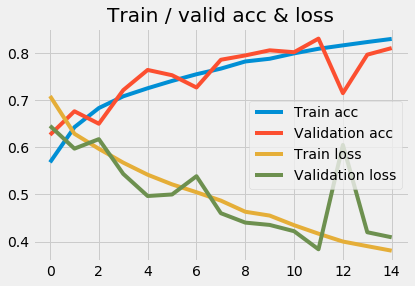

In [27]:
# Plot train and test accuracy & loss vs # of epochs

trn_acc  = history.history['acc']
val_acc  = history.history['val_acc']
trn_loss = history.history['loss']
val_loss = history.history['val_loss']

n_epochs = range(len(trn_acc))


plt.plot(n_epochs, trn_acc, label = 'Train acc')
plt.plot(n_epochs, val_acc, label = 'Validation acc')
plt.plot(n_epochs, trn_loss, label = 'Train loss')
plt.plot(n_epochs, val_loss, label = 'Validation loss')
plt.title('Train / valid acc & loss')
plt.legend()
plt.plot()

In [29]:
# Predict for new imgs

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
    path = '/content/' + fn
    img = image.load_img(path, target_size = (150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a dog")
    else:
        print(fn + " is a cat")

Saving cat.jpg to cat.jpg
[1.]
cat.jpg is a dog


In [0]:
# Well it doesn't work too well :)
# We need more epochs for a big model like this.